In [1]:
from datetime import datetime

import numpy as np
import talib as ta

from btopt import Engine, ExtendedDecimal, Order, Strategy
from btopt.util import logger_test

In [2]:
def parse_date(epoch):
    return datetime.fromtimestamp(epoch / 1_000_000_000).strftime("%Y-%m-%d %H:%M:%S")


class SimpleMovingAverageCrossover(Strategy):
    def __init__(self, fast_period: int = 10, slow_period: int = 20, risk_percent=0.1):
        super().__init__()
        self.fast_period = fast_period
        self.slow_period = slow_period
        self.warmup_period = 1

        self.risk_percentage = risk_percent

        self.fast_ma = None
        self.slow_ma = None

        # self.add_indicator(
        #     SimpleMovingAverage,
        #     "SMA20",
        #     parameters={"period": 20, "price_type": "close", "symbol": "EURUSD"},
        # )

        self.total = 0

    def on_data(self) -> None:
        bar = self.datas[self._primary_symbol].get(index=0)
        close_prices = self.datas[self._primary_symbol].get(
            size=self.slow_period, value="close"
        )[::-1]

        if len(close_prices) < self.slow_period:
            return

        fast_ma = ta.SMA(
            np.array(close_prices).astype(float), timeperiod=self.fast_period
        )[-1]
        slow_ma = ta.SMA(
            np.array(close_prices).astype(float), timeperiod=self.slow_period
        )[-1]
        # sma_value = sma_value = self.get_indicator_output("SMA20", "SMA20_sma")

        # logger_main.warning(f"TALIB: {slow_ma} | BTOPT: {sma_value}")

        current_position = self.get_current_position(bar.ticker)
        if (self.fast_ma is not None) and (self.slow_ma is not None):
            prev_diff = self.fast_ma - self.slow_ma
            diff = fast_ma - slow_ma

            if (diff > 0) and (prev_diff <= 0):
                # Bullish crossover
                if current_position <= 0:
                    position_size = self.calculate_position_size(
                        bar.ticker,
                        bar.close,
                    )

                    size = abs(current_position) + position_size
                    self.buy(bar.ticker, size)
                    self.total += 1
            elif (diff < 0) and (prev_diff >= 0):
                # Bearish crossover
                if current_position >= 0:
                    position_size = self.calculate_position_size(
                        bar.ticker,
                        bar.close,
                    )

                    size = abs(current_position) + position_size
                    self.sell(bar.ticker, size)
                    self.total += 1

        # Update MA values for next iteration
        self.fast_ma = fast_ma
        self.slow_ma = slow_ma

    def on_order_update(self, order: Order) -> None:
        if order.status == order.Status.FILLED:
            # logger_test.info(
            #     f"Order {order.id} filled | Time = {order.get_last_fill_timestamp()}; Price = {order.get_last_fill_price()}; Direction: {order.details.direction}"
            # )
            ...

    def on_trade_update(self, trade) -> None:
        if trade.status == trade.Status.CLOSED:
            logger_test.info(
                f"--------- TRADE COMPLETED -----------\n\
                ID: {trade.id}\n\
                DIRECTION: {trade.direction}\n\
                SIZE: {trade.initial_size}\n\n\
                ENTRY_TIME: {trade.entry_timestamp}\n\
                ENTRY_PRICE: {trade.entry_price}\n\
                SL_PRICE: {trade.entry_price * 0.99 if trade.direction.value == 1 else trade.entry_price * 1.01}\n\n\
                EXIT_TIME: {trade.exit_timestamp}\n\
                EXIT_PRICE: {trade.exit_price}\n\
                PNL: {trade.metrics.pnl}\n\
                ---------------------------------------\n\
                \n\n\
                "
            )

In [3]:
from btopt.data.dataloader import CSVDataLoader


def run_backtest():
    # Initialize the engine
    engine = Engine()

    # Load data

    start_date = "2021-01-01"
    end_date = "2023-01-01"

    symbol = "BTCUSDT"
    dataloader = CSVDataLoader(symbol, "1m", start_date=start_date, end_date=end_date)
    engine.resample_data(dataloader, "1d")

    # symbol = "ES=F"
    # dataloader = YFDataloader(symbol, "1d", start_date=start_date, end_date=end_date)
    # engine.add_data(dataloader)

    # # Create and add the strategy
    # strategy = SimpleMovingAverageCrossover(
    #     "SMA Crossover", fast_period=10, slow_period=20
    # )

    # engine.add_strategy(Empty, ctf, htf)
    engine.add_strategy(SimpleMovingAverageCrossover, fast_period=10, slow_period=20)

    # Set up the backtest configuration

    initial_capital = ExtendedDecimal("100000")
    commission_rate = ExtendedDecimal("0")
    config = {
        "initial_capital": initial_capital,
        "commission_rate": commission_rate,
    }
    engine.set_config(config)

    # Run the backtest
    try:
        logger_test.info("Starting backtest")
        reporter = engine.run()

        return reporter
    except Exception as e:
        logger_test.error(f"Error during backtest: {e}", exc_info=True)

In [4]:
reporter = run_backtest()

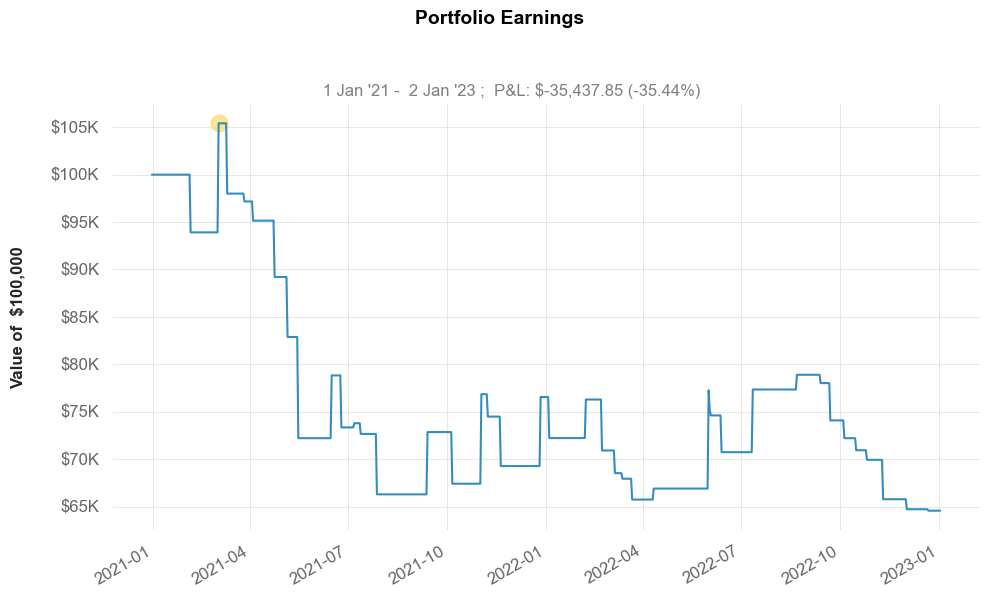

In [5]:
reporter.plot_equity_curve()

In [6]:
metrics = reporter.get_metrics_data()
metrics

,timestamp,cash,equity,asset_value,liabilities,open_pnl,closed_pnl,portfolio_return,realized_pnl,unrealized_pnl
0,2021-01-01,100000.00,100000.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00
1,2021-01-01,100000.00,100000.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00
2,2021-01-02,100000.00,100000.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00
3,2021-01-03,100000.00,100000.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00
4,2021-01-04,100000.00,100000.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
728,2022-12-29,81386.83,64562.15,0.0,16824.68,0.0,0.0,0.0,-49746.22,276.78
729,2022-12-30,81386.83,64562.15,0.0,16824.68,0.0,0.0,0.0,-49746.22,189.95
730,2022-12-31,81386.83,64562.15,0.0,16824.68,0.0,0.0,0.0,-49746.22,211.49
731,2023-01-01,81386.83,64562.15,0.0,16824.68,0.0,0.0,0.0,-49746.22,281.01
